<a href="https://colab.research.google.com/github/RgomezRo/capstone/blob/main/Time%20series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [230]:
AUTORUNTHISWONDERFULLPROGRAM = True

In [231]:
pip install squarify

In [232]:
!pip install wget

In [233]:
!pip install calmap

In [234]:
#@title imports

### importamos librerías

'''
instalar:
- plotly
- calmap
- folium
- wget
'''

#analisis
import pandas as pd 
import numpy as np
import sys
from scipy.stats import kurtosis, skew 
from scipy import stats
from google.colab import output
import datetime as dt

np.set_printoptions(threshold=sys.maxsize)
pd.set_option('max_rows', 99999)
pd.set_option('max_colwidth', 400)

#visualización
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import calmap
import folium

#paletas
confirmados='#393e46'
fallecidos='#ff2e63'

import wget
import os
import json

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data Loading

In [235]:
#@title Funcion de lectura de data sets read_FAO()
import requests 
import os 
def read_FAO(fileName):
	
	Database = fileName + ".csv"

	if(os.path.isfile(Database)!=True):

		file_url = "https://fenixservices.fao.org/faostat/static/bulkdownloads/"+fileName+".zip"
			
		r = requests.get(file_url, stream = True) 

		with open("temporalFile.zip", "wb") as file: 
			for block in r.iter_content(chunk_size = 1024): 
				if block: 
					file.write(block) 
			
		!unzip temporalFile.zip 

			
	df = pd.read_csv(Database, encoding = "ISO-8859-1")

	return df




In [236]:
#@title Lectura de datos

### leer origenes

df_food_balances = read_FAO("FoodBalanceSheets_E_All_Data_(Normalized)")

df_emissions = read_FAO("Emissions_Totals_E_All_Data_(Normalized)")

df_emissions_share = read_FAO("Environment_Emissions_by_Sector_E_All_Data_(Normalized)")

df_food_transport = read_FAO("Environment_Transport_E_All_Data_(Normalized)")

df_waste_disposal = read_FAO("Emissions_Agriculture_Waste_Disposal_E_All_Data_(Normalized)")

#### leer cluster de Pere

df_cluster_paises = pd.read_csv("/content/drive/MyDrive/01. Data science/00. Proyecto Capstone/Cluster_Paises.csv", encoding = "ISO-8859-1")

### Filters and transformations 

df_food_balances["Year"] = pd.to_datetime(df_food_balances.Year, format='%Y')
df_emissions["Year"] = pd.to_datetime(df_emissions.Year, format='%Y')
df_emissions_share["Year"] = pd.to_datetime(df_emissions.Year, format='%Y')
df_food_transport["Year"] = pd.to_datetime(df_food_transport.Year, format='%Y')
df_waste_disposal["Year"] = pd.to_datetime(df_waste_disposal.Year, format='%Y')



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DtypeWarning: Columns (13) have mixed types.Specify dtype option on import or set low_memory=False.
  import sys


# Data filtering



In [237]:
#@title Function to show nulls and gaps in data : show_gaps_data { display-mode: "form" }
def show_gaps_data(df_input,):
  # create a smaller df

  df_input["MeasuredItem"]= df_input["Item"] + "-"+ df_input["Element"]

  # in order to show and fill na we aggregate a little bit the info

  short_df = df_input[["Year", "Value","MeasuredItem"]]


  # show  gaps in the data

  gb_df_ = short_df.pivot_table(index = ["Year"], columns = ['MeasuredItem'], values = "Value", aggfunc = sum).isnull()
  #gb_df_= gb_df_.fillna(0)

  order_of_columns = list(gb_df_.sum().sort_values().index)
  
  gb_df_ = gb_df_[order_of_columns]


  plt.figure(figsize = (20, 10))
  plot = sns.heatmap(gb_df_, cbar = True, cmap = "inferno")
  plot.set_title("Null values in dataset");

  
  return df_input







In [238]:
#@title Function to create tree map : plot_tree_map()

#libraries
import matplotlib.pyplot as plt
import squarify # pip install squarify (algorithm for treemap)

def plot_tree_map(input_df, column_label, column_value,graph_title, string_to_repleace="Dummie", percentage_of_record_not_showed = 2):
  # Change color
  # squarify.plot(sizes=[13,22,35,5], label=["group A", "group B", "group C", "group D"], color=["red","green","blue", "grey"], alpha=.4 )
  # plt.axis('off')
  # plt.show()
  # values and labels
  # values and labels
  function_df =input_df.groupby(column_label).sum().reset_index()
  function_df[column_label] = function_df[column_label].str.replace(string_to_repleace, '', regex=False)
  function_df = function_df[function_df[column_value]> function_df[column_value].sum()*(percentage_of_record_not_showed/100)]
  function_df.reset_index()
  my_values = function_df[column_value]
  my_pct = function_df[column_value]/function_df[column_value].sum()
  labels = ['{} \n {:.2f}%'.format(column_label , pct*100) for column_label , pct in zip(function_df[column_label], my_pct)]

  #plot
  plt.figure(figsize = (34, 10))
  squarify.plot(sizes = my_values, label = labels,edgecolor="white", linewidth=2,  alpha = 0.5, text_kwargs={'fontsize':18,'color':"black"})
  plt.title(" \n"+ graph_title+" \n",fontsize = 23, fontweight = "bold")


In [239]:
#@title Data description function DataDesc
def DataDesc(df):
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values    
    summary['Uniques'] = df.nunique().values
    summary['First Value'] = df.loc[0].values
    summary['Second Value'] = df.loc[1].values
    summary['Third Value'] = df.loc[2].values

    for name in summary['Name'].value_counts().index:
        summary.loc[summary['Name'] == name, 'Entropy'] = round(stats.entropy(df[name].value_counts(normalize=True), base=2),2) 
    
    return summary

In [240]:
#@title Function for null nnalysis : Null_Count()

def Null_Count(df):
    df_null = df.isnull().sum().sort_values(ascending = False).rename('Null').reset_index()

    null_count = df_null['Null']
    null_percent = (null_count * 100) / (df.shape[0])

    df_null = pd.concat([df_null['index'],null_count,null_percent], axis=1, keys=['Column','Null_Count','Null_Percent'])

    return df_null[df_null['Null_Count'] != 0]





## Emissions data

Los datos de emisiones, como veremos a continuación contienen multitud de información.

Además de venir separados en **dos datasets distintos**, la información contienen **agrupaciones** por distintas metodologías todas ellas relacionadas con la **cadena de producción**:
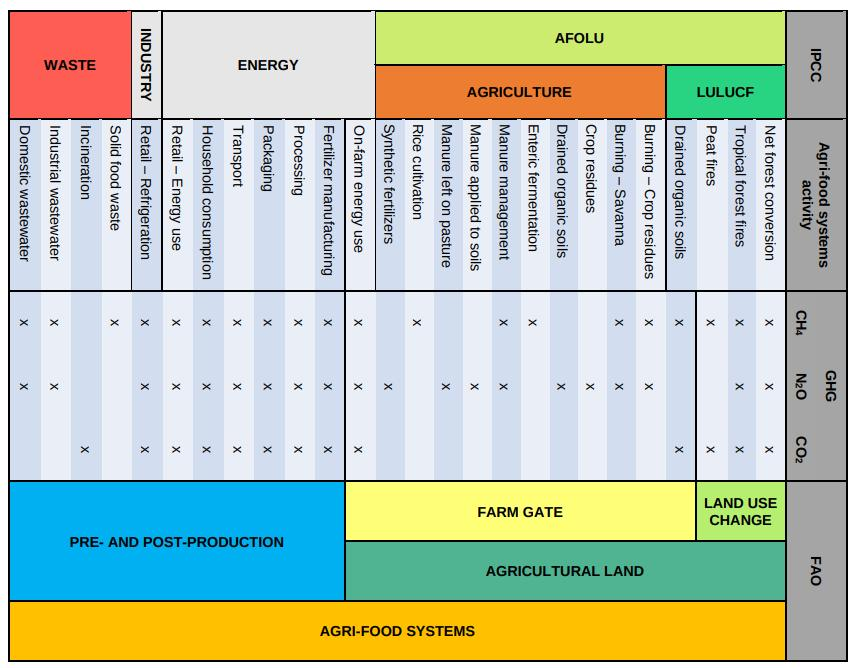

Por otro lado disponemos de **distintos tipos de emisiones**.


Para nuestro objetivo, cuánto vale lo que comemos , solo nos interesa aquellos que influyan en la huella de carbono, por lo tanto nos fijaremos en los datos de **carbono equivalente**

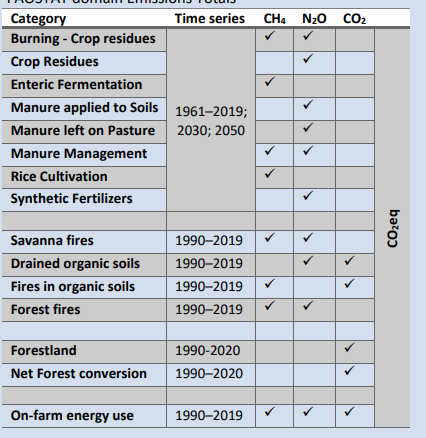



**Explicación data set "Emission Shares" AKA df_emission_share**



> The FAOSTAT Emissions shares domain disseminates data on absolute levels of greenhouse
gas (GHG) emissions and their shares in the GHG total by all sectors.

> Data are provided by
country and relevant regional groups, over the period 1990-2019, by economic sector and
agri-food system component.

> Emissions and their shares are provided in CO2 equivalent
(CO2eq), carbon dioxide (CO2), methane (CH4), nitrous oxide (N2O) and of the aggregate
fluorinated gases (F-gases).

> Emissions estimates are grouped in activities from farm gate,
land use change and pre- and post-production processes.


> *   The activity data and the emissions
and removals from agriculture, forestry and other land use (AFOLU), as well as those
relevant to farm gate and land use change processes, are taken from FAO (2021).
*   Emissions
from pre- and post-production processes are calculated by FAO based on UNSD, IEA and
other third-party activity data, as well as by integrating emission information from the
PRIMAP-hist dataset v2.3 (Gütschow et al., 2021).

**Explicación data set "Emissions" AKA df_emission**


> The FAOSTAT domain Emissions Totals summarizes the greenhouse gas (GHG) emissions disseminated in the FAOSTAT Climate Change Emissions domains, generated from agriculture and forest land.

> They consist of methane (CH4), nitrous oxide (N2O) and carbon dioxide (CO2) emissions from crop and livestock activities, forest management and include land use and land use change processes. 





 

A modo de curiosidad, aunque no vaya con nuestro proyecto, estas son los **distintos tipos de emisiones** presentes en el data set

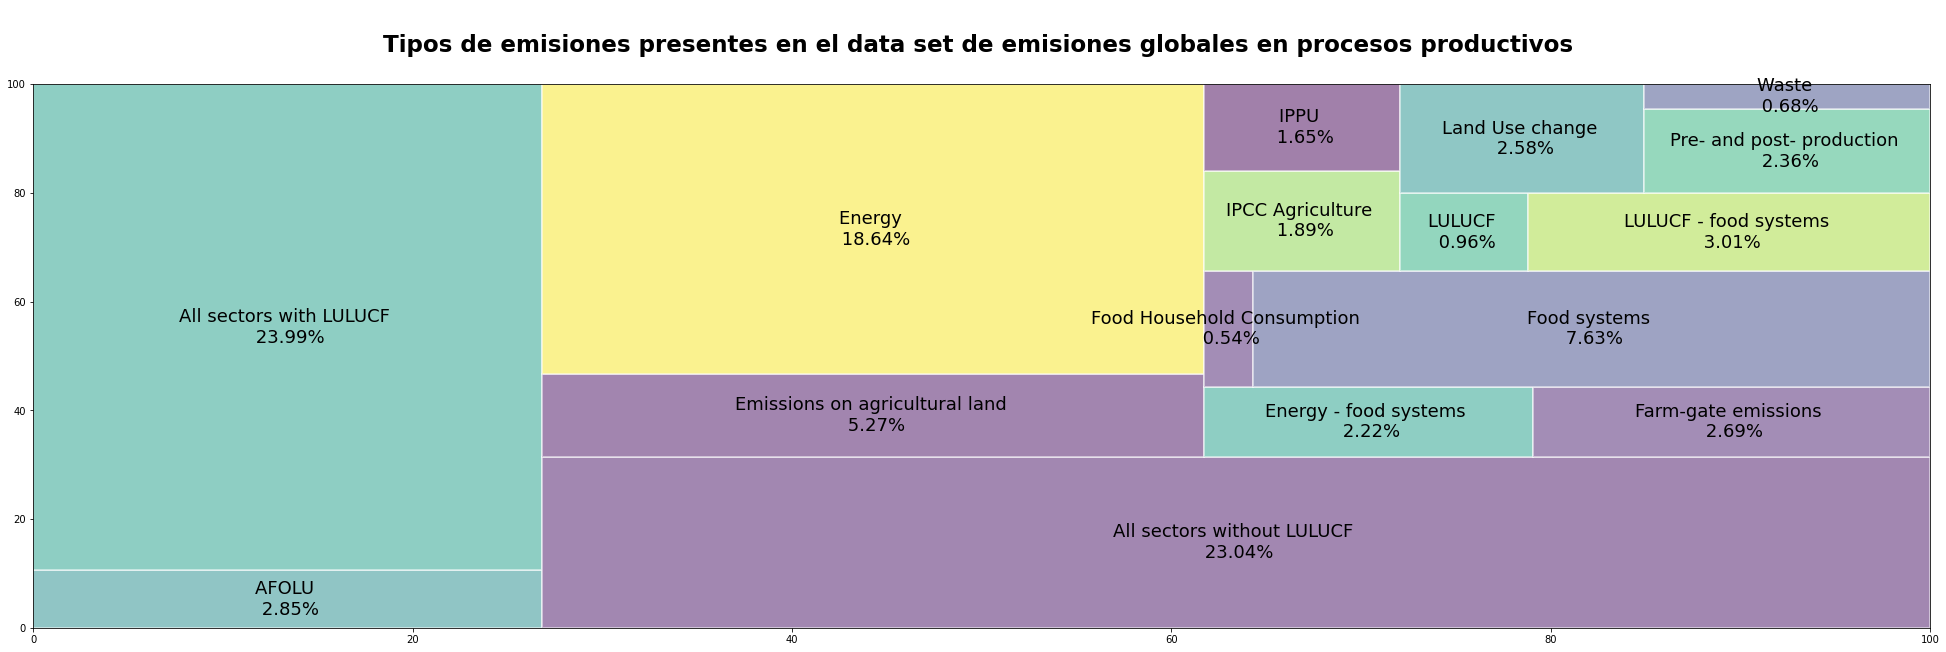

In [241]:
plot_tree_map(df_emissions_share, "Item", "Value","Tipos de emisiones presentes en el data set de emisiones globales en procesos productivos",percentage_of_record_not_showed=0.5)

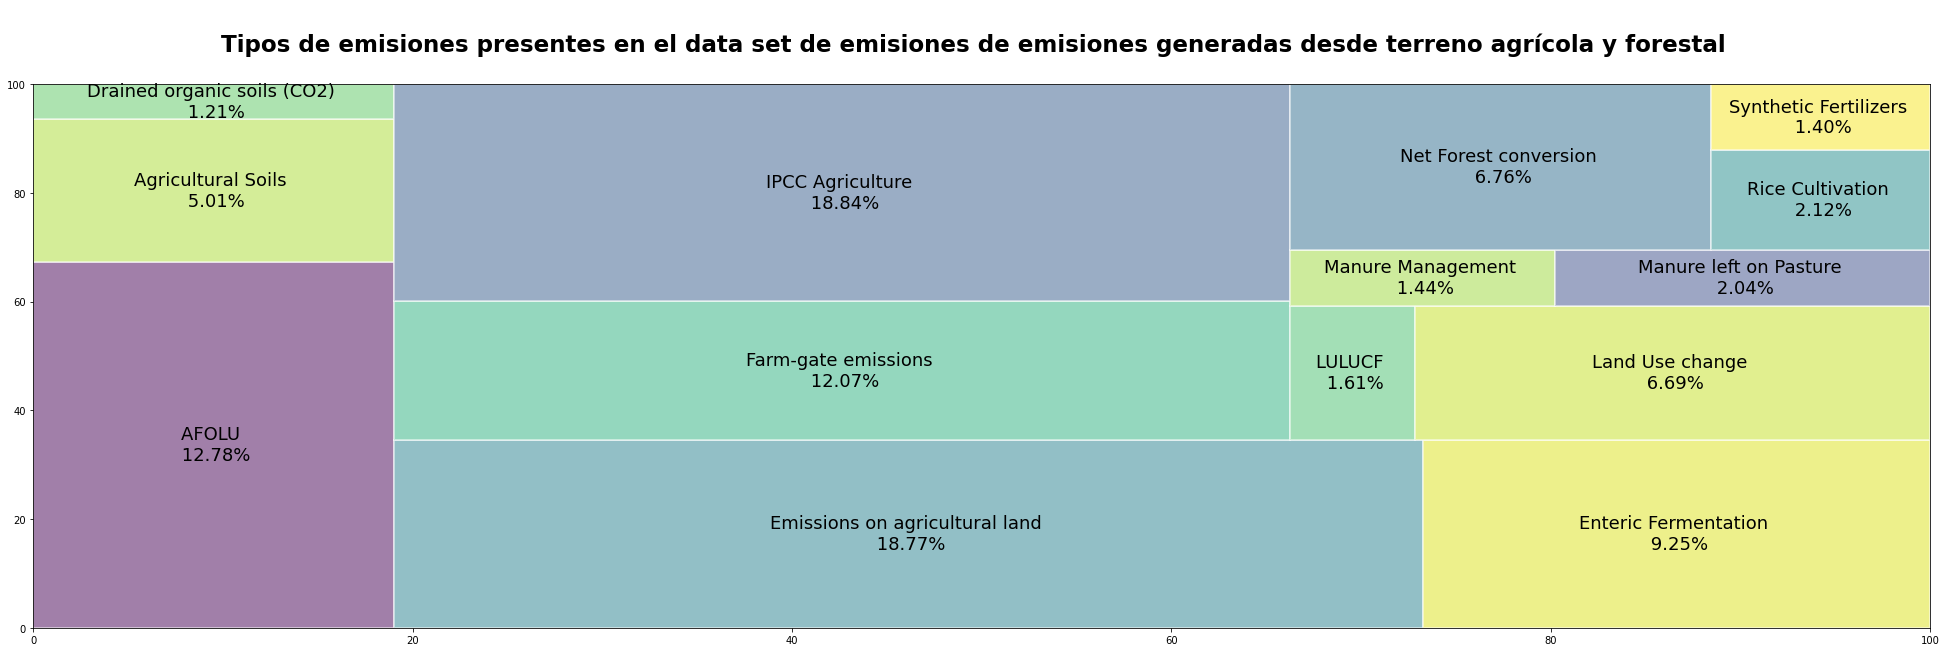

In [242]:
plot_tree_map(df_emissions, "Item", "Value","Tipos de emisiones presentes en el data set de emisiones de emisiones generadas desde terreno agrícola y forestal ",percentage_of_record_not_showed=1)

In [243]:
display(df_emissions["Element"].unique())
display(df_emissions_share["Element"].unique())
display(df_emissions["Item"].unique())
display(df_emissions_share["Item"].unique())

array(['Emissions (CH4)', 'Emissions (CO2eq) from CH4 (AR5)',
       'Emissions (CO2eq) (AR5)', 'Emissions (N2O)',
       'Emissions (CO2eq) from N2O (AR5)', 'Direct emissions (N2O)',
       'Indirect emissions (N2O)', 'Emissions (CO2)'], dtype=object)

array(['Emissions Share (CO2eq) (AR5)', 'Emissions Share (CO2)',
       'Emissions Share (CH4)', 'Emissions Share (N2O)',
       'Emissions (CO2eq) (AR5)', 'Emissions (CO2)', 'Emissions (CH4)',
       'Emissions (N2O)', 'Emissions (F-gases)',
       'Emissions Share (F-gases)'], dtype=object)

array(['Enteric Fermentation', 'Manure Management', 'Rice Cultivation',
       'Synthetic Fertilizers', 'Manure applied to Soils',
       'Manure left on Pasture', 'Crop Residues',
       'Burning - Crop residues', 'Net Forest conversion', 'Forestland',
       'Savanna fires', 'Fires in humid tropical forests', 'Forest fires',
       'Fires in organic soils', 'On-farm energy use', 'IPCC Agriculture',
       'Agricultural Soils', 'LULUCF', 'AFOLU',
       'Emissions on agricultural land', 'Farm-gate emissions',
       'Land Use change', 'Drained organic soils',
       'Drained organic soils (CO2)', 'Drained organic soils (N2O)'],
      dtype=object)

array(['Farm-gate emissions', 'Land Use change',
       'Pre- and post- production', 'Fertilizers Manufacturing',
       'IPCC Agriculture', 'LULUCF', 'On-farm electricity use',
       'LULUCF - food systems', 'Energy', 'Food Processing',
       'Energy - food systems', 'Food Transport', 'IPPU', 'Food Retail',
       'Food Waste Disposal', 'Waste', 'Waste - food systems',
       'Food Household Consumption', 'Food Packaging',
       'All sectors with LULUCF', 'All sectors without LULUCF', 'Other',
       'Food systems', 'AFOLU', 'Emissions on agricultural land',
       'IPPU - food systems', 'Food Transport - International Bunkers',
       'International bunkers', 'International bunkers - food systems'],
      dtype=object)

In [244]:
## Filtrar datos no agregados (https://www.fao.org/faostat/en/#data/EM)
agro_measures_to_preserve = ["Burning - Crop residues","Crop Residues","Drained organic soils","Enteric Fermentation","Fires in organic soils","Forest fires","Forestland","Manure Management","Manure applied to Soils","Manure left on Pasture","Net Forest conversion","On-farm energy use","Rice Cultivation","Savanna fires","Synthetic Fertilizers" ]
share_measures_to_preserve = ["Fertilizers Manufacturing","Food Household Consumption","Food Packaging","Food Processing","Food Retail","Food Transport","Food Transport - International Bunkers","Food Waste Disposal","On-farm electricity use"]

## Filtrar datos de solo CO2eq
df_emissions = df_emissions[df_emissions["Element"]=="Emissions (CO2eq) (AR5)"]
df_emissions_share = df_emissions_share[df_emissions_share["Element"]=="Emissions (CO2eq) (AR5)"]

## Deshacerse de los agrupados
df_emissions = df_emissions[df_emissions["Item"].isin(agro_measures_to_preserve)]
df_emissions_share = df_emissions_share[df_emissions_share["Item"].isin(share_measures_to_preserve)]

## index reset
df_emissions = df_emissions.reset_index(drop=True)
df_emissions_share = df_emissions_share.reset_index(drop=True)



Volvemos a montar los gráficos, esta vez sin agregados

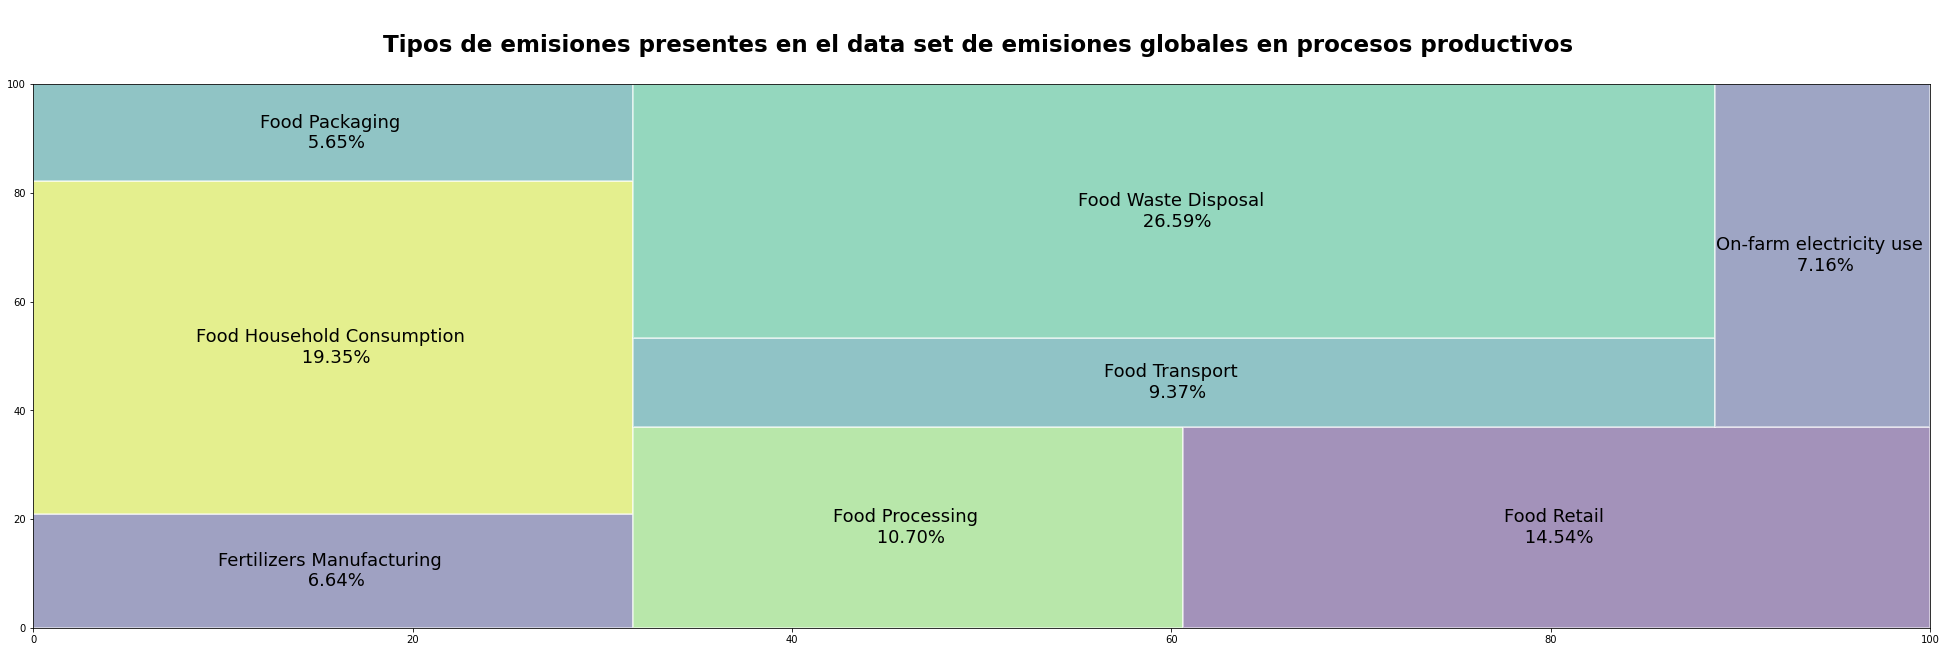

In [245]:
plot_tree_map(df_emissions_share, "Item", "Value","Tipos de emisiones presentes en el data set de emisiones globales en procesos productivos",percentage_of_record_not_showed=0.5)

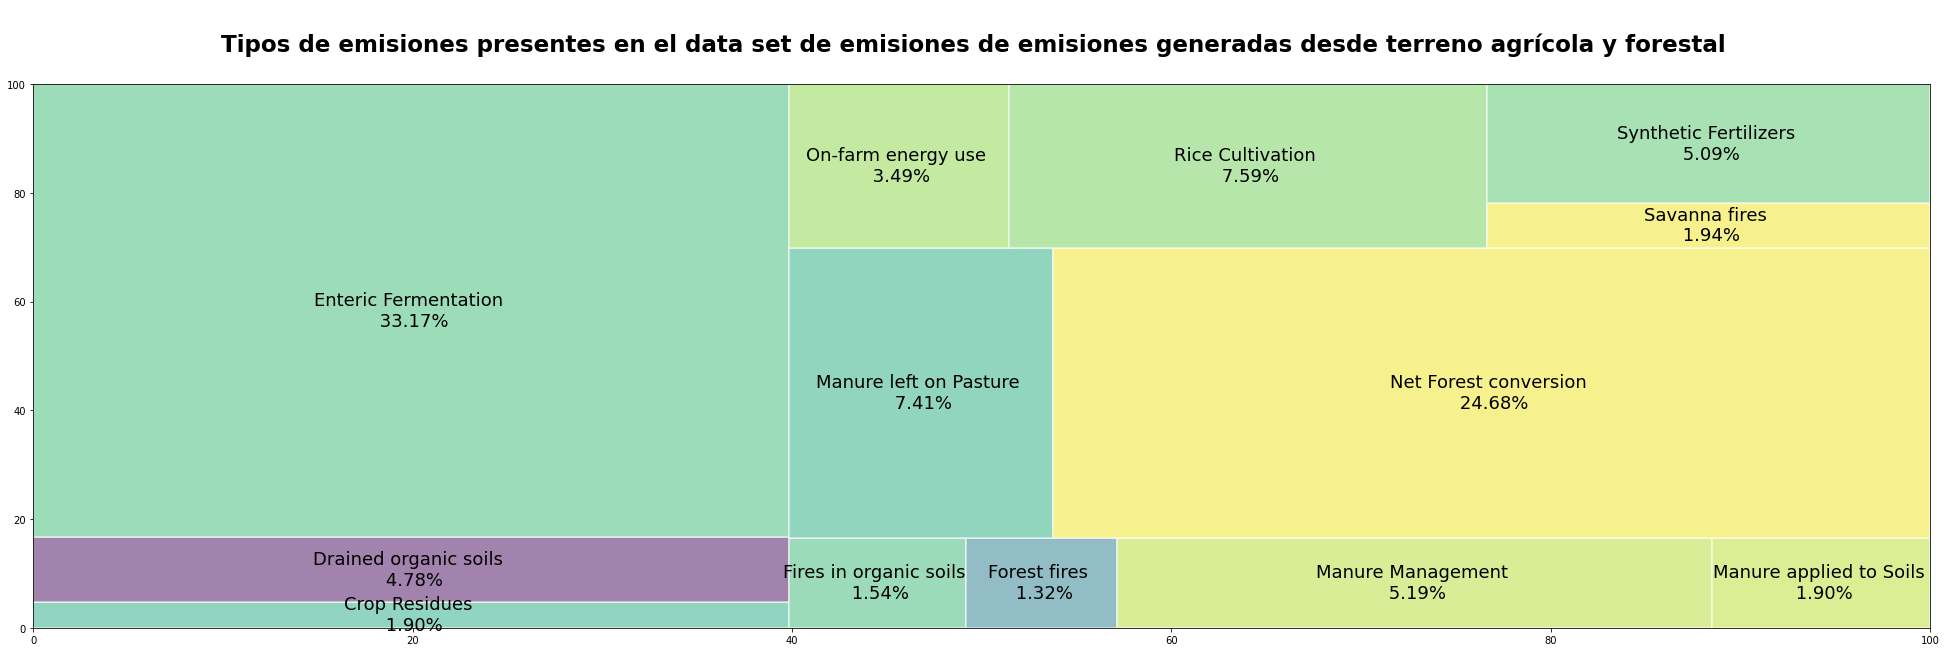

In [246]:
plot_tree_map(df_emissions, "Item", "Value","Tipos de emisiones presentes en el data set de emisiones de emisiones generadas desde terreno agrícola y forestal ",percentage_of_record_not_showed=1)

In [247]:
display(df_emissions["Element"].unique())
display(df_emissions_share["Element"].unique())
display(df_emissions["Item"].unique())
display(df_emissions_share["Item"].unique())

array(['Emissions (CO2eq) (AR5)'], dtype=object)

array(['Emissions (CO2eq) (AR5)'], dtype=object)

array(['Enteric Fermentation', 'Manure Management', 'Rice Cultivation',
       'Synthetic Fertilizers', 'Manure applied to Soils',
       'Manure left on Pasture', 'Crop Residues',
       'Burning - Crop residues', 'Net Forest conversion', 'Forestland',
       'Savanna fires', 'Forest fires', 'Fires in organic soils',
       'On-farm energy use', 'Drained organic soils'], dtype=object)

array(['Fertilizers Manufacturing', 'On-farm electricity use',
       'Food Processing', 'Food Transport', 'Food Retail',
       'Food Waste Disposal', 'Food Household Consumption',
       'Food Packaging', 'Food Transport - International Bunkers'],
      dtype=object)

## Food Balances sheet
Este data set contiene información de mucho tipo acerca de cada país.
De momento dejamos dicha información disponible para su uso futuro.


In [248]:
df_food_balances.groupby(["Element","Unit"]).count().reset_index()[["Element","Unit"]]

,Element,Unit
0,Domestic supply quantity,1000 tonnes
1,Export Quantity,1000 tonnes
2,Fat supply quantity (g/capita/day),g/capita/day
3,Feed,1000 tonnes
4,Food,1000 tonnes
5,Food supply (kcal/capita/day),kcal/capita/day
6,Food supply quantity (kg/capita/yr),kg
7,Import Quantity,1000 tonnes
8,Losses,1000 tonnes
9,Other uses (non-food),1000 tonnes


Lo que si que podemos ir viendo ya la información de alimentos que usaremos para nuestro modelo y como se reparten en la dieta mundial

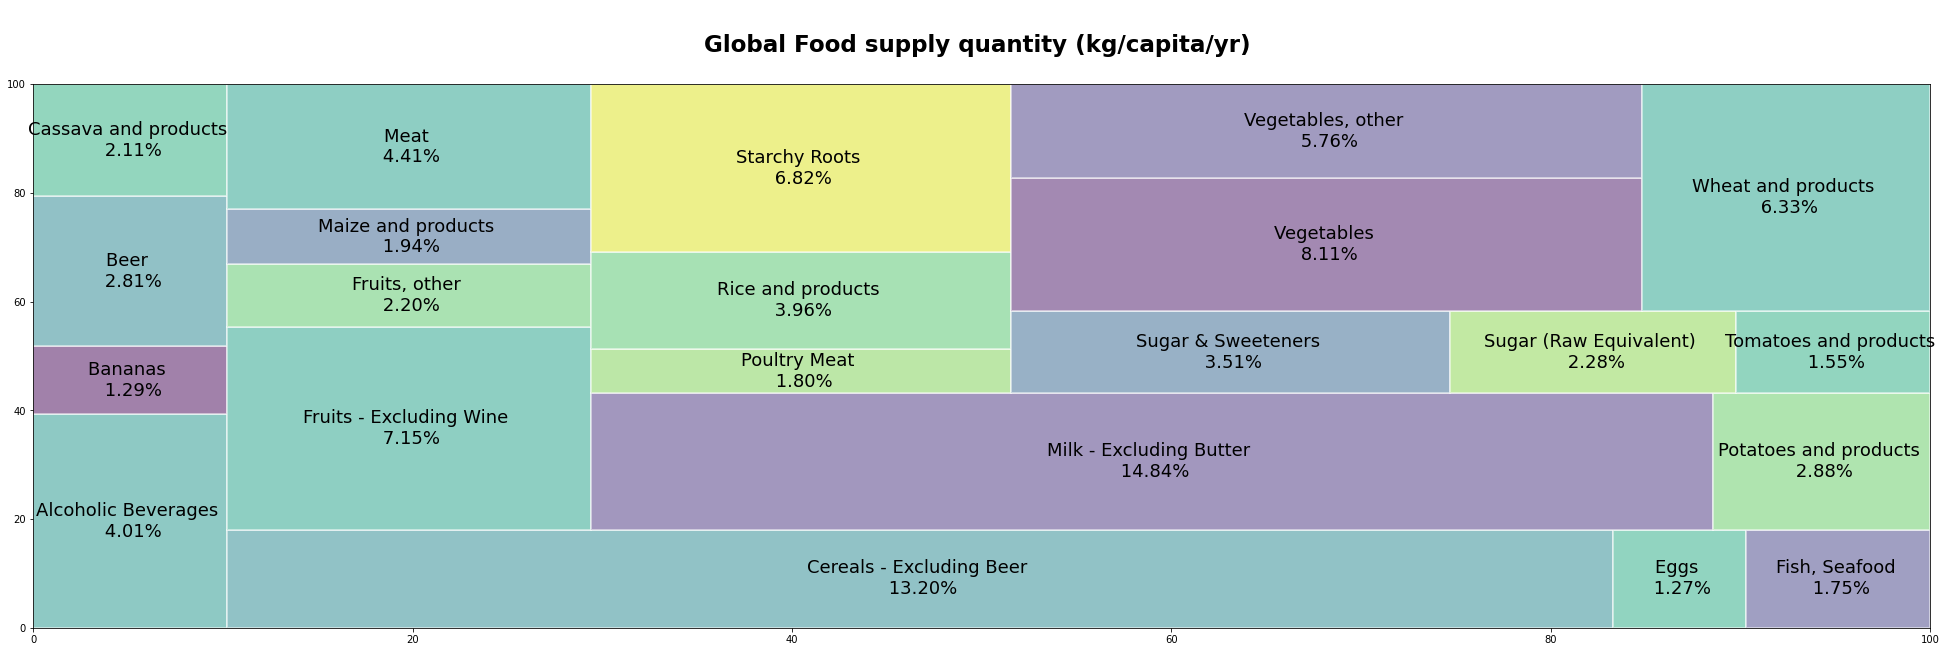

In [249]:
plot_tree_map(df_food_balances[df_food_balances["Element"]=="Food supply quantity (kg/capita/yr)"], "Item", "Value","Global Food supply quantity (kg/capita/yr)",percentage_of_record_not_showed=1)

# Análisis de los atributos y su cumplimentación (nulos)

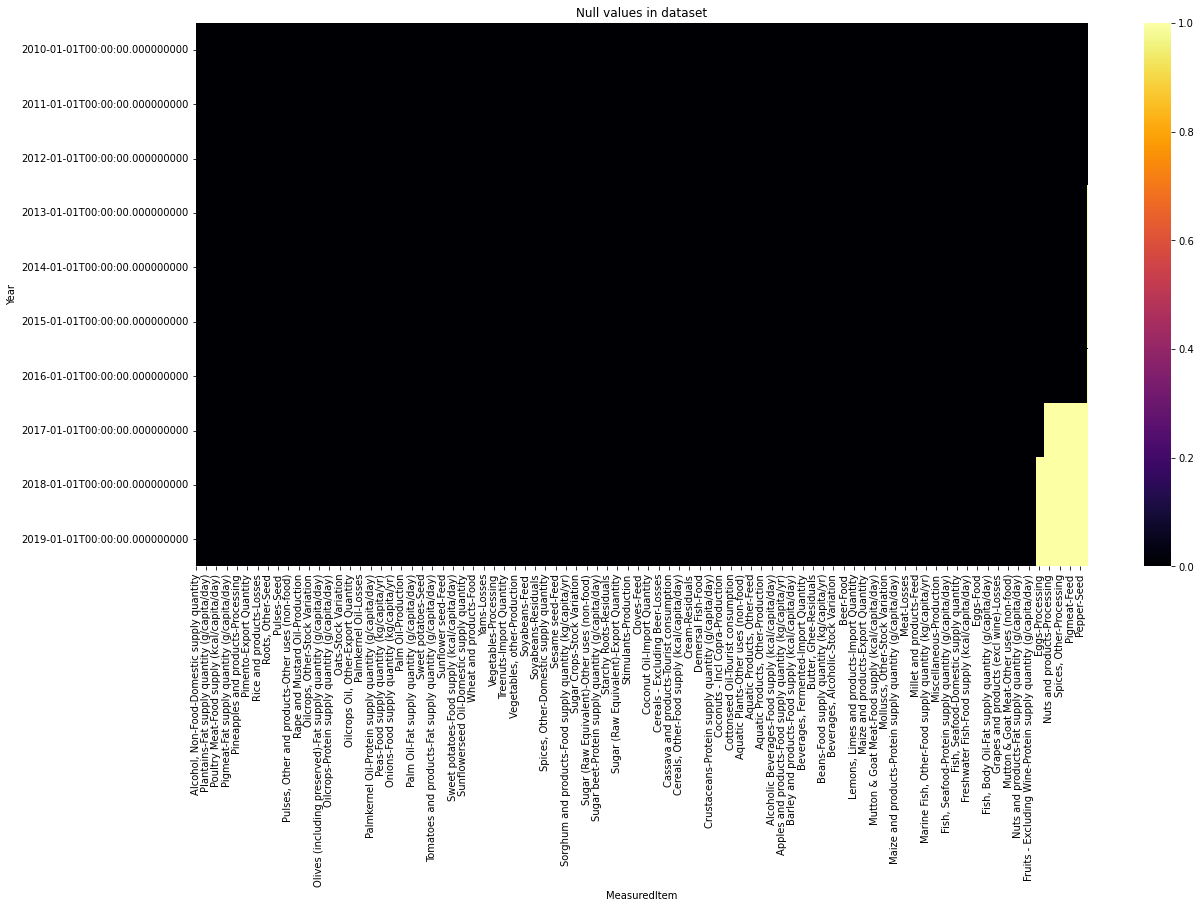

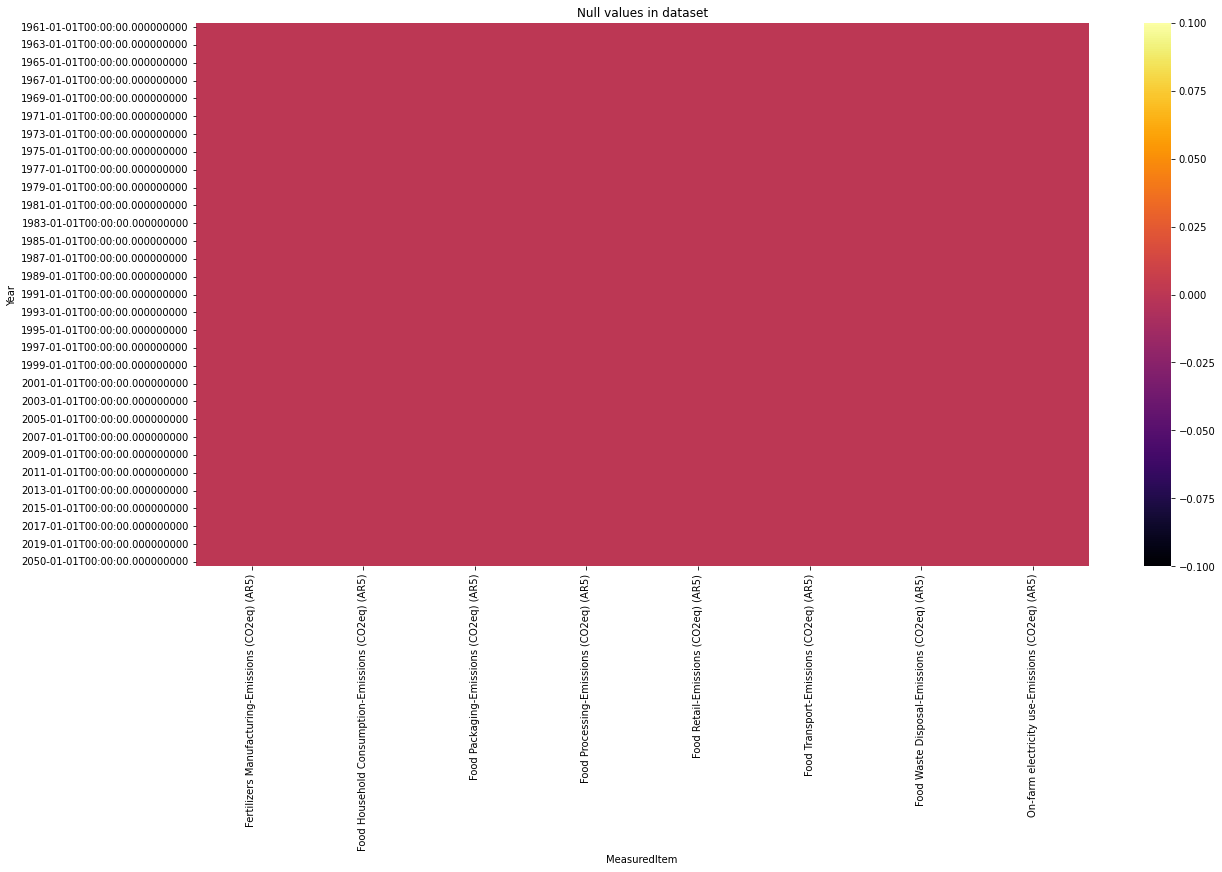

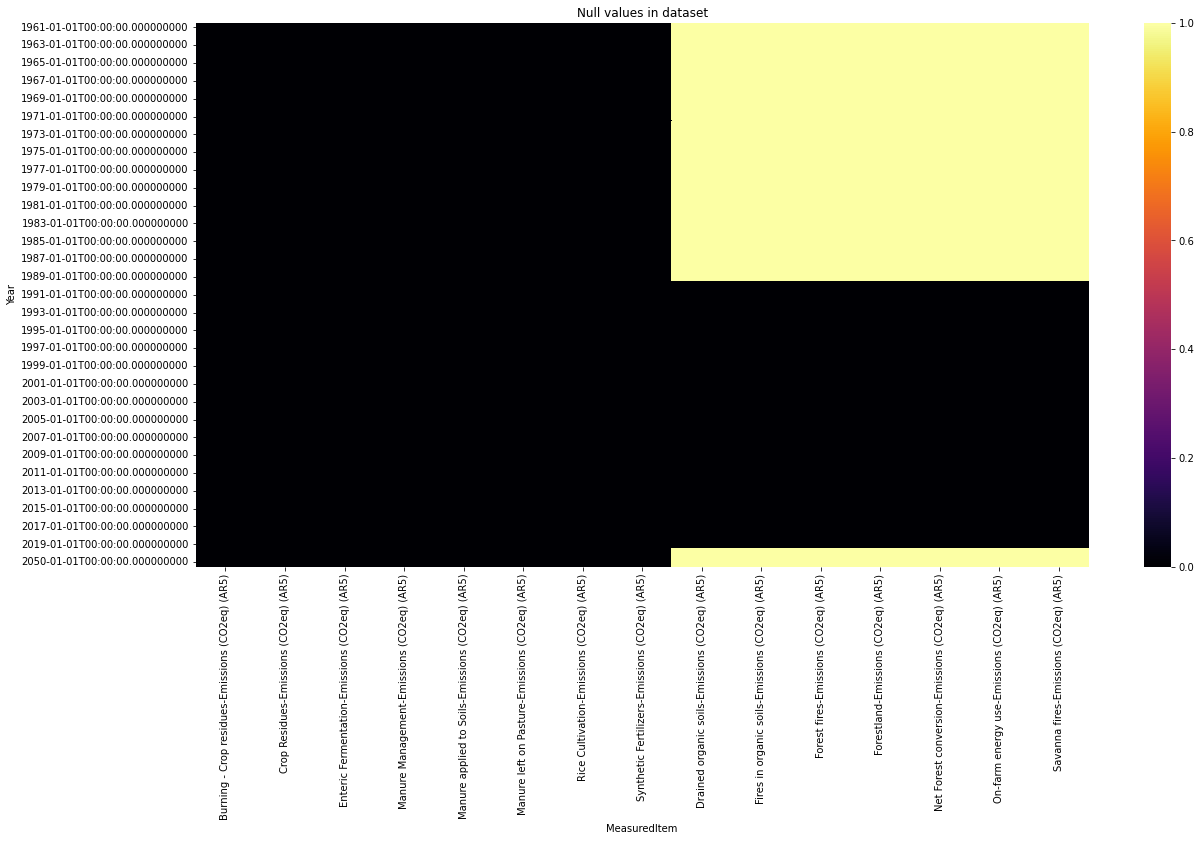

In [250]:
### mostrar donde se encuentran los gaps, tanto nulos como lineas inexistentes
df_food_balances = show_gaps_data(df_food_balances)
df_emissions_share = show_gaps_data(df_emissions_share)
df_emissions = show_gaps_data(df_emissions)


In [251]:
DataDesc(df_food_balances)

### Vemos que tiene nulos y que hay que convertir a fecha el año

Dataset Shape: (2975297, 12)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,Area Code,int64,0,216,2,2,2,7.73
1,Area,object,0,216,Afghanistan,Afghanistan,Afghanistan,7.73
2,Item Code,int64,0,123,2501,2501,2501,6.88
3,Item,object,0,120,Population,Population,Population,6.82
4,Element Code,int64,0,18,511,511,511,3.98
5,Element,object,0,18,Total Population - Both sexes,Total Population - Both sexes,Total Population - Both sexes,3.98
6,Year Code,int64,0,10,2010,2011,2012,3.32
7,Year,datetime64[ns],0,10,2010-01-01 00:00:00,2011-01-01 00:00:00,2012-01-01 00:00:00,3.32
8,Unit,object,0,5,1000 persons,1000 persons,1000 persons,1.37
9,Value,float64,63553,68992,29186.0,30117.0,31161.0,7.50


In [252]:
DataDesc(df_emissions)
### Vemos que no tiene nulos y que hay que convertir a fecha el año

Dataset Shape: (167497, 15)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,Area Code,int64,0,280,2,2,2,8.00
1,Area,object,0,280,Afghanistan,Afghanistan,Afghanistan,8.00
2,Item Code,int64,0,15,5058,5058,5058,3.84
3,Item,object,0,15,Enteric Fermentation,Enteric Fermentation,Enteric Fermentation,3.84
4,Element Code,int64,0,1,723113,723113,723113,0.00
5,Element,object,0,1,Emissions (CO2eq) (AR5),Emissions (CO2eq) (AR5),Emissions (CO2eq) (AR5),0.00
6,Year Code,int64,0,61,1961,1962,1963,5.79
7,Year,datetime64[ns],0,61,1961-01-01 00:00:00,1962-01-01 00:00:00,1963-01-01 00:00:00,5.79
8,Source Code,int64,0,2,3050,3050,3050,0.45
9,Source,object,0,2,FAO TIER 1,FAO TIER 1,FAO TIER 1,0.45


In [253]:
DataDesc(df_cluster_paises)
### Vemos que el cluster tiene 3 divisiones

Dataset Shape: (205, 3)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,Unnamed: 0,int64,0,205,0,1,2,7.68
1,Area,object,0,205,Afghanistan,Albania,Algeria,7.68
2,cluster,int64,0,3,1,1,1,1.31


# Transformación de la información
En esta sección:


*   Rellenamos nulos mediante una función de interpolación
*   Calculamos columnas mediante una función que nos permite seleccionar la información a mostrar



In [254]:
#@title Función de interpolación de nulos: my_interp()
def my_interp(x):
    if x.notnull().sum() > 1:
      return x.interpolate(method='nearest').ffill().bfill()
    else:
      if(x.isna().all()):
        return x.fillna(0)
      else:
        return x.ffill().bfill()

In [255]:
#@title Funcion de generación de dataset basados en datos de la FAO transpuestos: generate_columns_for_dataset()
def generate_columns_for_dataset(old_df, columns_to_transpose,columns_to_transpose_by,column_with_value,pathToGenerateConfigFile,auto_run = False):
  filtering_list = []
  df_filtered = old_df
  continue_with_old_config = "N"
  df_to_return = pd.DataFrame() 
  

  if(os.path.isfile(pathToGenerateConfigFile)):
    if(auto_run):
      continue_with_old_config = "Y"  
    else:
      continue_with_old_config = input("\r\nYa existe un archivo con este nombre y esta ruta, pulse [Y] si desea recuperarlo:\r\n "   )

  if(continue_with_old_config=="Y" ):
    with open(pathToGenerateConfigFile, "r") as read_file:
   
      df_to_return = pd.read_csv(pathToGenerateConfigFile, encoding = "ISO-8859-1")


  else:  
    for column_index in range(len(columns_to_transpose)): 

      current_column = columns_to_transpose[column_index]
      array_of_measured_items =  df_filtered.groupby(current_column).count().add_suffix("_count").reset_index()[current_column]
      
      output.clear()
      if(column_index != (len(columns_to_transpose)-1)):
        
        display(array_of_measured_items)
        value_to_filter = int(input("\r\nIntroduzca el índice de un [" + current_column + "] para filtrar:\r\n "   ))
        filtering_list.append(array_of_measured_items[value_to_filter])

      else:

        # this is the last type of row to transpose.
        decision = int(input(" \r\n Introduzca [1] si desea incluir todos los valores de ["+current_column + "]. \r\n Si prefiere filtrar los valores pulse [2]: \r\n" ))
        
        if(decision == 2):

          display(array_of_measured_items)
          value_to_filter = int(input("\r\nIntroduzca el índice de un [" + current_column + "] para filtrar:\r\n "   ))
          filtering_list.append(array_of_measured_items[value_to_filter])

          
      display(filtering_list)

      if(len(filtering_list)>0):

        for row_index in range(len(filtering_list)):

          row_to_filter = filtering_list[row_index]
          
          col = columns_to_transpose[row_index]
          df_filtered = df_filtered[df_filtered[col]==row_to_filter]
 
    columns_to_generate_prefix = "" 

    if(len(filtering_list)>0):
        for row_index in range(len(filtering_list)):
          row_to_filter = filtering_list[row_index]
          # we only filter if it is NOT the last column (this way we will be able to traspose it correctly)
          #><
          if(row_index < (len(columns_to_transpose)-1)):
            col = columns_to_transpose[row_index]
            df_filtered = df_filtered[df_filtered[col]==row_to_filter]
            columns_to_generate_prefix = (columns_to_generate_prefix + " " + row_to_filter).strip()

    
    last_granularity = columns_to_transpose[-1]
    columns_to_group_by = []
    columns_to_group_by.extend(columns_to_transpose_by)
    columns_to_group_by.append(last_granularity)

    gb_df= df_filtered.groupby(columns_to_group_by).sum().reset_index()
    df_to_return = df_filtered.groupby(columns_to_transpose_by).sum().reset_index()[columns_to_transpose_by]
    
    
    for last_level in gb_df[last_granularity].unique():
      
      column_name = columns_to_generate_prefix+ " " +last_level
      output.clear()
      display("Generating column "+ column_name)
      partial_df_to_merge = gb_df[gb_df[last_granularity]==last_level].copy()

      

      partial_df_to_merge[column_name] = partial_df_to_merge[column_with_value]

       #### INTERPOLATION FOR NULLS CALCULATION BASED ON AGRUPATIONS ALREADY DONE
      partial_df_to_merge[column_name] = partial_df_to_merge.groupby(columns_to_group_by)[column_name].apply(lambda x:my_interp(x))
      
      
      partial_df_to_merge.reset_index()



      list_column_to_use = []
      list_column_to_use.append(column_name)
      list_column_to_use.extend(columns_to_transpose_by) 
      
      partial_df_to_merge_cleaned = partial_df_to_merge[list_column_to_use].copy()
      df_to_return = pd.merge(df_to_return, partial_df_to_merge_cleaned, on = columns_to_transpose_by, how = "left")
  output.clear()
  
  if(continue_with_old_config!="Y"):
    df_to_return.to_csv(pathToGenerateConfigFile,index=False)
  
  display(df_to_return.head(3).T.head(10))    
  
  return df_to_return
    
  
  

    
        
      
    





## Generación de columnas de alimentos por país
En esta sección creamos una columna por cada alimento país y año y rellenamos los nulos que puedan haber.

In [256]:
path ="/content/drive/MyDrive/01. Data science/00. Proyecto Capstone/transposicion_food.csv"

### if you dont have the file the order of input is 
###    -   n for the question 
###    -   [6] for selection of Element -- Food supply quantity (kg/capita/yr)
###    -   [1] [ALL ITEMS] for selection of Items   

feature_foods = generate_columns_for_dataset(df_food_balances,["Element","Item"],["Area","Year"],"Value",path,AUTORUNTHISWONDERFULLPROGRAM)


,0,1,2
Area,Afghanistan,Afghanistan,Afghanistan
Year,2010-01-01,2011-01-01,2012-01-01
Food supply quantity (kg/capita/yr) Alcoholic Beverages,0.11,0.1,0.09
Food supply quantity (kg/capita/yr) Animal fats,1.41,1.41,1.43
Food supply quantity (kg/capita/yr) Apples and products,2.83,2.63,2.62
Food supply quantity (kg/capita/yr) Bananas,0.73,0.92,1.53
Food supply quantity (kg/capita/yr) Barley and products,1.09,1.85,1.3
Food supply quantity (kg/capita/yr) Beer,0.1,0.09,0.09
"Food supply quantity (kg/capita/yr) Beverages, Alcoholic",0.0,0.0,0.0
Food supply quantity (kg/capita/yr) Bovine Meat,4.58,4.66,4.3


In [257]:
### antes veíamos que food balances contenía nulos 

Null_Count(df_food_balances)

,Column,Null_Count,Null_Percent
0,Value,63553,2.136022


In [258]:
### veamos cuantos nulos contiene nuestro nuevo generado dataset,estos nulos corresponden a años para los que no aparece información
Null_Count(feature_foods).head(10)

,Column,Null_Count,Null_Percent
0,"Food supply quantity (kg/capita/yr) Alcohol, Non-Food",2092,98.031865
1,Food supply quantity (kg/capita/yr) Palm kernels,2072,97.094658
2,"Food supply quantity (kg/capita/yr) Meat, Aquatic Mammals",2054,96.251172
3,Food supply quantity (kg/capita/yr) Cottonseed,2009,94.142455
4,Food supply quantity (kg/capita/yr) Sugar beet,1664,77.975633
5,Food supply quantity (kg/capita/yr) Sugar non-centrifugal,1626,76.194939
6,Food supply quantity (kg/capita/yr) Ricebran Oil,1410,66.073102
7,Food supply quantity (kg/capita/yr) Sorghum and products,1126,52.764761
8,Food supply quantity (kg/capita/yr) Millet and products,1106,51.827554
9,Food supply quantity (kg/capita/yr) Sugar cane,1016,47.610122


In [259]:
#### INTERPOLATION FOR NULLS CALCULATION BASED ON AGRUPATIONS ALREADY DONE
for column in feature_foods.columns[2:]:
  output.clear()
  display("Generating column "+column)
  feature_foods[column] = feature_foods.groupby("Area")[column].apply(lambda x:my_interp(x))
      

'Generating column Food supply quantity (kg/capita/yr) Meat, Aquatic Mammals'

In [260]:
### veamos cuantos nulos contiene nuestro nuevo generado dataset
Null_Count(feature_foods).head(10)

,Column,Null_Count,Null_Percent


## Generación de columnas de emisiones agrícolas y forestales por país
En esta sección creamos una columna por cada alimento país y año y rellenamos los nulos que puedan haber.

In [261]:
path ="/content/drive/MyDrive/01. Data science/00. Proyecto Capstone/transposicion_emisiones_CO2_eq.csv"

### Si no tienes el archivo el orden de imputación es: 
###    -   n for the question
###    -   [2] All items for selection of [Element]
###    -   [3] Para la selección de las emisiones (CO2eq) 

feature_emissions_CO2_eq = generate_columns_for_dataset(df_emissions,["Element"],["Area","Year"],"Value",path,AUTORUNTHISWONDERFULLPROGRAM)


,0,1,2
Area,Afghanistan,Afghanistan,Afghanistan
Year,1961-01-01,1962-01-01,1963-01-01
Emissions (CO2eq) (AR5),10783.733,10899.2617,11258.7528


In [262]:
path ="/content/drive/MyDrive/01. Data science/00. Proyecto Capstone/transposicion_emisiones_CO2_eq_produccion.csv"

### Si no tienes el archivo el orden de imputación es: 
###    -   n for the question
###    -   [2] All items for selection of [Element]
###    -   [3] Para la selección de las emisiones (CO2eq) 

feature_emissions_CO2_eq_prod = generate_columns_for_dataset(df_emissions_share,["Element"],["Area","Year"],"Value",path,AUTORUNTHISWONDERFULLPROGRAM)


,0,1,2
Area,Afghanistan,Afghanistan,Afghanistan
Year,1961-01-01,1971-01-01,1972-01-01
Emissions (CO2eq) (AR5),43.9521,40.8015,40.1179


In [263]:
feature_emissions_CO2_eq.append(feature_emissions_CO2_eq_prod).groupby(["Area","Year"]).sum().reset_index().head()


,Area,Year,Emissions (CO2eq) (AR5)
0,Afghanistan,1961-01-01,10827.6851
1,Afghanistan,1962-01-01,10899.2617
2,Afghanistan,1963-01-01,11258.7528
3,Afghanistan,1964-01-01,11454.0798
4,Afghanistan,1965-01-01,11717.5625


In [264]:
### For emissions we need to transform the data to a per capita amd maybe more operations to be similar to the other columns dimensions
path ="/content/drive/MyDrive/01. Data science/00. Proyecto Capstone/transposicion_poblacion.csv"

### Si no tienes el archivo el orden de imputación es: 
###    -   n for the question
###    -   [16] [Total Population] for selection of [Element]
###    -   [1] Para la selección de todos los [Item] 

feature_poblation = generate_columns_for_dataset(df_food_balances,["Element","Item"],["Area","Year"],"Value",path,AUTORUNTHISWONDERFULLPROGRAM)


,0,1,2
Area,Afghanistan,Afghanistan,Afghanistan
Year,2010-01-01,2011-01-01,2012-01-01
Total Population - Both sexes Population,29186.0,30117.0,31161.0


In [265]:
#@title Generación de producto cartesiano { display-mode: "form" }
#@title
feature_foods["Year"] = pd.to_datetime(feature_foods.Year, format='%Y-%m-%d')
feature_emissions_CO2_eq["Year"] = pd.to_datetime(feature_emissions_CO2_eq.Year, format='%Y-%m-%d')
feature_poblation["Year"] = pd.to_datetime(feature_poblation.Year, format='%Y-%m-%d')

In [266]:
#@title
### Before merging, in order to obtain a little bit more of data we would create a cartesian product
min_date=feature_foods["Year"].min()
display(min_date)
max_date=feature_foods["Year"].max()
display(max_date)
unique_areas = sorted(list(feature_foods["Area"].unique()))
date_range = pd.date_range(min_date, max_date, freq = "Y")
print("We have a total of {} years".format(len(date_range)))

cartesian_product = pd.MultiIndex.from_product([date_range,unique_areas], names = ["Year", "Area"])
cartesian_product


Timestamp('2010-01-01 00:00:00')

Timestamp('2019-01-01 00:00:00')

We have a total of 9 years


MultiIndex([('2010-12-31',                        'Afghanistan'),
            ('2010-12-31',                             'Africa'),
            ('2010-12-31',                            'Albania'),
            ('2010-12-31',                            'Algeria'),
            ('2010-12-31',                           'Americas'),
            ('2010-12-31',                             'Angola'),
            ('2010-12-31',                'Antigua and Barbuda'),
            ('2010-12-31',                          'Argentina'),
            ('2010-12-31',                            'Armenia'),
            ('2010-12-31',                               'Asia'),
            ...
            ('2018-12-31',                            'Vanuatu'),
            ('2018-12-31', 'Venezuela (Bolivarian Republic of)'),
            ('2018-12-31',                           'Viet Nam'),
            ('2018-12-31',                     'Western Africa'),
            ('2018-12-31',                       'Western As

In [267]:
#@title
full_df = pd.DataFrame(index = cartesian_product).reset_index()
full_df["Year"] =  pd.to_datetime(df_food_balances["Year"], format='%Y-%m-%d')
display(full_df.head())
full_df = pd.merge(full_df, feature_foods, on = ['Area','Year'], how = 'left')

full_df[full_df["Area"]== "Western Europe"].head()

,Year,Area
0,2010-01-01,Afghanistan
1,2011-01-01,Africa
2,2012-01-01,Albania
3,2013-01-01,Algeria
4,2014-01-01,Americas


,Year,Area,Food supply quantity (kg/capita/yr) Alcoholic Beverages,Food supply quantity (kg/capita/yr) Animal fats,Food supply quantity (kg/capita/yr) Apples and products,Food supply quantity (kg/capita/yr) Bananas,Food supply quantity (kg/capita/yr) Barley and products,Food supply quantity (kg/capita/yr) Beer,"Food supply quantity (kg/capita/yr) Beverages, Alcoholic",Food supply quantity (kg/capita/yr) Bovine Meat,...,"Food supply quantity (kg/capita/yr) Molluscs, Other",Food supply quantity (kg/capita/yr) Palm kernels,Food supply quantity (kg/capita/yr) Pelagic Fish,Food supply quantity (kg/capita/yr) Sugar beet,Food supply quantity (kg/capita/yr) Sugar non-centrifugal,Food supply quantity (kg/capita/yr) Sunflower seed,Food supply quantity (kg/capita/yr) Yams,"Food supply quantity (kg/capita/yr) Alcohol, Non-Food",Food supply quantity (kg/capita/yr) Cottonseed,"Food supply quantity (kg/capita/yr) Meat, Aquatic Mammals"
209,2010-01-01,Western Europe,104.97,12.45,15.71,7.56,0.43,68.96,4.77,18.46,...,3.29,0.0,4.82,0.0,0.0,0.03,0.00,0.0,0.0,0.0
423,2017-01-01,Western Europe,103.96,13.05,14.92,9.82,0.92,68.11,4.45,16.92,...,2.31,0.0,4.66,0.0,0.0,0.01,0.03,0.0,0.0,0.0
637,2011-01-01,Western Europe,110.61,11.98,15.74,7.86,0.33,69.81,4.67,18.17,...,3.39,0.0,5.14,0.0,0.0,0.03,0.00,0.0,0.0,0.0
851,2011-01-01,Western Europe,110.61,11.98,15.74,7.86,0.33,69.81,4.67,18.17,...,3.39,0.0,5.14,0.0,0.0,0.03,0.00,0.0,0.0,0.0
1065,2013-01-01,Western Europe,102.63,12.22,17.29,8.28,0.39,64.64,6.06,17.78,...,2.71,0.0,4.68,0.0,0.0,0.04,0.04,0.0,0.0,0.0


In [268]:
#@title
### Mezclamos los dos datasets cogiendo de base el de food balances
display(full_df.head()) 
display(feature_emissions_CO2_eq.head())
                   


,Year,Area,Food supply quantity (kg/capita/yr) Alcoholic Beverages,Food supply quantity (kg/capita/yr) Animal fats,Food supply quantity (kg/capita/yr) Apples and products,Food supply quantity (kg/capita/yr) Bananas,Food supply quantity (kg/capita/yr) Barley and products,Food supply quantity (kg/capita/yr) Beer,"Food supply quantity (kg/capita/yr) Beverages, Alcoholic",Food supply quantity (kg/capita/yr) Bovine Meat,...,"Food supply quantity (kg/capita/yr) Molluscs, Other",Food supply quantity (kg/capita/yr) Palm kernels,Food supply quantity (kg/capita/yr) Pelagic Fish,Food supply quantity (kg/capita/yr) Sugar beet,Food supply quantity (kg/capita/yr) Sugar non-centrifugal,Food supply quantity (kg/capita/yr) Sunflower seed,Food supply quantity (kg/capita/yr) Yams,"Food supply quantity (kg/capita/yr) Alcohol, Non-Food",Food supply quantity (kg/capita/yr) Cottonseed,"Food supply quantity (kg/capita/yr) Meat, Aquatic Mammals"
0,2010-01-01,Afghanistan,0.11,1.41,2.83,0.73,1.09,0.10,0.00,4.58,...,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0
1,2011-01-01,Africa,27.92,0.77,2.25,11.65,3.43,11.87,1.06,5.81,...,0.05,0.0,3.81,0.00,0.04,0.09,30.69,0.0,0.0,0.0
2,2012-01-01,Albania,34.23,3.48,24.48,5.22,1.00,26.50,1.43,14.70,...,0.31,0.0,3.34,0.00,0.00,0.00,0.00,0.0,0.0,0.0
3,2013-01-01,Algeria,3.71,0.80,13.80,6.47,15.48,3.27,0.14,5.26,...,0.02,0.0,2.55,0.00,0.00,0.00,0.00,0.0,0.0,0.0
4,2014-01-01,Americas,71.55,2.98,8.44,18.16,0.71,62.16,3.64,29.33,...,1.45,0.0,3.18,0.05,1.84,0.25,1.08,0.0,0.0,0.0


,Area,Year,Emissions (CO2eq) (AR5)
0,Afghanistan,1961-01-01,10783.7330
1,Afghanistan,1962-01-01,10899.2617
2,Afghanistan,1963-01-01,11258.7528
3,Afghanistan,1964-01-01,11454.0798
4,Afghanistan,1965-01-01,11717.5625


In [269]:
#@title
Null_Count(full_df).head(7)

,Column,Null_Count,Null_Percent
0,Food supply quantity (kg/capita/yr) Rice and products,5,0.259605
1,Food supply quantity (kg/capita/yr) Tea (including mate),5,0.259605
2,Food supply quantity (kg/capita/yr) Groundnuts,5,0.259605
3,Food supply quantity (kg/capita/yr) Cloves,5,0.259605
4,Food supply quantity (kg/capita/yr) Cassava and products,5,0.259605
5,"Food supply quantity (kg/capita/yr) Beverages, Fermented",5,0.259605
6,Food supply quantity (kg/capita/yr) Beans,5,0.259605


In [270]:
#@title
full_df[full_df["Food supply quantity (kg/capita/yr) Animal fats"].isna()].T.head(2)


,397,455,669,883,1097
Year,2011-01-01 00:00:00,2013-01-01 00:00:00,2013-01-01 00:00:00,2011-01-01 00:00:00,2011-01-01 00:00:00
Area,Sudan,Burundi,Burundi,Burundi,Burundi


In [271]:
#@title
### sudan y burundi son los que tienen todos los valores a nulo, de hecho lo podemos comprobar fácilmente
display(Null_Count(full_df[~full_df["Area"].isin(["Sudan","Burundi"])]))

## intrapolamos el rellenado de nulos otra vez por area

#### INTERPOLATION FOR NULLS CALCULATION BASED ON AGRUPATIONS ALREADY DONE
for column in full_df.columns[2:]:
  output.clear()
  display("Generating column "+column)
  full_df[column] = full_df.groupby("Area")[column].apply(lambda x:my_interp(x))


'Generating column Food supply quantity (kg/capita/yr) Meat, Aquatic Mammals'

In [272]:
#@title
Null_Count(full_df)

,Column,Null_Count,Null_Percent


In [273]:
feature_emissions_CO2_eq = pd.merge( feature_poblation,feature_emissions_CO2_eq, on = ['Area','Year'], how = 'left')
feature_emissions_CO2_eq.T
# los huecos son por las estimaciones de 1961-1990 y de las predicciones hasta 2050 [Estos datos se eliminan a futuro]

,0,1,2,3,4,5,6,7,8,9,...,2124,2125,2126,2127,2128,2129,2130,2131,2132,2133
Area,Afghanistan,Afghanistan,Afghanistan,Afghanistan,Afghanistan,Afghanistan,Afghanistan,Afghanistan,Afghanistan,Afghanistan,...,Zimbabwe,Zimbabwe,Zimbabwe,Zimbabwe,Zimbabwe,Zimbabwe,Zimbabwe,Zimbabwe,Zimbabwe,Zimbabwe
Year,2010-01-01 00:00:00,2011-01-01 00:00:00,2012-01-01 00:00:00,2013-01-01 00:00:00,2014-01-01 00:00:00,2015-01-01 00:00:00,2016-01-01 00:00:00,2017-01-01 00:00:00,2018-01-01 00:00:00,2019-01-01 00:00:00,...,2010-01-01 00:00:00,2011-01-01 00:00:00,2012-01-01 00:00:00,2013-01-01 00:00:00,2014-01-01 00:00:00,2015-01-01 00:00:00,2016-01-01 00:00:00,2017-01-01 00:00:00,2018-01-01 00:00:00,2019-01-01 00:00:00
Total Population - Both sexes Population,29186.0,30117.0,31161.0,32270.0,33371.0,34414.0,35383.0,36296.0,37172.0,38042.0,...,12698.0,12894.0,13115.0,13350.0,13587.0,13815.0,14030.0,14237.0,14439.0,14645.0
Emissions (CO2eq) (AR5),17189.1237,16988.1169,16809.8089,29474.6933,17058.7005,15953.8211,16429.5673,16221.3375,15942.6356,16625.8987,...,26618.7308,26110.7693,25363.4888,24332.6004,22530.3985,23812.6113,98631.2076,98724.3286,99176.4699,99367.8244


In [274]:
#@title Convertimos las emisiones a per capita 
feature_emissions_CO2_eq["feature_emissions_CO2_eq"] = feature_emissions_CO2_eq[" Emissions (CO2eq) (AR5)"]/feature_emissions_CO2_eq["Total Population - Both sexes Population"]	

In [275]:
feature_emissions_CO2_eq.head()
feature_emissions_CO2_eq=feature_emissions_CO2_eq.drop(["Total Population - Both sexes Population"," Emissions (CO2eq) (AR5)"],axis=1)

In [276]:
feature_emissions_CO2_eq.head()

,Area,Year,feature_emissions_CO2_eq
0,Afghanistan,2010-01-01,0.588951
1,Afghanistan,2011-01-01,0.564071
2,Afghanistan,2012-01-01,0.539450
3,Afghanistan,2013-01-01,0.913378
4,Afghanistan,2014-01-01,0.511183


In [277]:
df_with_target = pd.merge(full_df, feature_emissions_CO2_eq, on = ['Area','Year'], how = 'left')

In [278]:
Null_Count(df_with_target).head(4)

,Column,Null_Count,Null_Percent
0,feature_emissions_CO2_eq,5,0.259605


In [279]:
df_with_target["feature_emissions_CO2_eq"] = df_with_target.groupby("Area")["feature_emissions_CO2_eq"].apply(lambda x:my_interp(x))
df_with_target[df_with_target["feature_emissions_CO2_eq"].isna()].T.head(2) 

""
Year
Area


In [280]:
df_area_code = df_food_balances.groupby(["Area","Area Code"]).sum().reset_index()[["Area","Area Code"]]
df_with_target = pd.merge(df_with_target, df_area_code, on = ['Area'], how = 'left')


In [281]:
feature_emissions_CO2_eq
feature_emissions_CO2_eq = pd.merge(feature_emissions_CO2_eq, df_area_code, on = ['Area'], how = 'left')


In [282]:
#@title Tenemos emisiones negativas para algunos países
### hay valores negativos
feature_emissions_CO2_eq[feature_emissions_CO2_eq["Area Code"]==272]
df_emissions[(df_emissions["Area Code"]==272) & (df_emissions["Element"]=="Emissions (CO2eq) (AR5)")].groupby("Year").sum()["Value"]

Year
2006-01-01   -27433.2698
2007-01-01   -26954.8347
2008-01-01   -28036.7958
2009-01-01   -27586.2645
2010-01-01   -28468.4600
2011-01-01     4350.1325
2012-01-01     4968.4893
2013-01-01     4894.7615
2014-01-01     4301.9512
2015-01-01     4043.5455
2016-01-01     7093.7225
2017-01-01     6776.9841
2018-01-01     6231.2334
2019-01-01     6714.3103
2030-01-01     8594.0711
2050-01-01     8691.8170
Name: Value, dtype: float64

In [283]:
Null_Count(df_with_target)

,Column,Null_Count,Null_Percent
0,Area Code,9,0.46729


In [284]:
df_with_target.rename(columns = {"feature_emissions_CO2_eq":"Emissions CO2eq tonnes/capita"}, inplace = True)


In [285]:
cols_to_drop = [

"Area"
    
]
df_with_target.drop(cols_to_drop, inplace = True, axis = 1)


In [286]:
# ------------------------------------------------------
# separate the dates for train, validation and test

train_index = sorted(list(df_with_target["Year"].unique()))[:-2]

valida_index = [sorted(list(df_with_target["Year"].unique()))[-2]]

test_index = [sorted(list(df_with_target["Year"].unique()))[-1]]

In [287]:
df_with_target.head()

,Year,Food supply quantity (kg/capita/yr) Alcoholic Beverages,Food supply quantity (kg/capita/yr) Animal fats,Food supply quantity (kg/capita/yr) Apples and products,Food supply quantity (kg/capita/yr) Bananas,Food supply quantity (kg/capita/yr) Barley and products,Food supply quantity (kg/capita/yr) Beer,"Food supply quantity (kg/capita/yr) Beverages, Alcoholic",Food supply quantity (kg/capita/yr) Bovine Meat,"Food supply quantity (kg/capita/yr) Butter, Ghee",...,Food supply quantity (kg/capita/yr) Pelagic Fish,Food supply quantity (kg/capita/yr) Sugar beet,Food supply quantity (kg/capita/yr) Sugar non-centrifugal,Food supply quantity (kg/capita/yr) Sunflower seed,Food supply quantity (kg/capita/yr) Yams,"Food supply quantity (kg/capita/yr) Alcohol, Non-Food",Food supply quantity (kg/capita/yr) Cottonseed,"Food supply quantity (kg/capita/yr) Meat, Aquatic Mammals",Emissions CO2eq tonnes/capita,Area Code
0,2010-01-01,0.11,1.41,2.83,0.73,1.09,0.10,0.00,4.58,1.00,...,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.588951,2.0
1,2011-01-01,27.92,0.77,2.25,11.65,3.43,11.87,1.06,5.81,0.45,...,3.81,0.00,0.04,0.09,30.69,0.0,0.0,0.0,2.302345,5100.0
2,2012-01-01,34.23,3.48,24.48,5.22,1.00,26.50,1.43,14.70,1.23,...,3.34,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.913455,3.0
3,2013-01-01,3.71,0.80,13.80,6.47,15.48,3.27,0.14,5.26,0.55,...,2.55,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.308102,4.0
4,2014-01-01,71.55,2.98,8.44,18.16,0.71,62.16,3.64,29.33,1.10,...,3.18,0.05,1.84,0.25,1.08,0.0,0.0,0.0,2.112703,5200.0


In [288]:
# ------------------------------------------------------
# split the data into train, validation and test dataset
# we "simulate" the test dataset to be the Kaggle test dataset

X_train = df_with_target[df_with_target["Year"].isin(train_index)].drop(['Emissions CO2eq tonnes/capita', "Year"], axis=1)
Y_train = df_with_target[df_with_target["Year"].isin(train_index)]['Emissions CO2eq tonnes/capita']

X_valida = df_with_target[df_with_target["Year"].isin(valida_index)].drop(['Emissions CO2eq tonnes/capita', "Year"], axis=1)
Y_valida = df_with_target[df_with_target["Year"].isin(valida_index)]['Emissions CO2eq tonnes/capita']

X_test = df_with_target[df_with_target["Year"].isin(test_index)].drop(['Emissions CO2eq tonnes/capita', "Year"], axis = 1)
Y_test = df_with_target[df_with_target["Year"].isin(test_index)]['Emissions CO2eq tonnes/capita']

In [289]:
import time
from string import punctuation

from xgboost import XGBRegressor
from xgboost import plot_importance

from sklearn.preprocessing import LabelEncoder

import itertools
import warnings

warnings.filterwarnings("ignore") # specify to ignore warning messages


st = time.time()

model = XGBRegressor(seed = 175)

model_name = str(model).split("(")[0]

day = str(dt.datetime.now()).split()[0].replace("-", "_")
hour = str(dt.datetime.now()).split()[1].replace(":", "_").split(".")[0]
t = str(day) + "_" + str(hour)

model.fit(X_train, Y_train, eval_metric = "rmse", 
    eval_set = [(X_train, Y_train), (X_valida, Y_valida)], 
    verbose = True, 
    early_stopping_rounds = 10)

et = time.time()

print("Training took {} minutes!".format((et - st)/60))

[21:49:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:5.40202	validation_1-rmse:5.63808
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:5.20103	validation_1-rmse:5.55882
[2]	validation_0-rmse:5.02457	validation_1-rmse:5.53177
[3]	validation_0-rmse:4.90266	validation_1-rmse:5.49043
[4]	validation_0-rmse:4.74687	validation_1-rmse:5.47591
[5]	validation_0-rmse:4.55778	validation_1-rmse:5.40594
[6]	validation_0-rmse:4.42367	validation_1-rmse:5.38268
[7]	validation_0-rmse:4.25176	validation_1-rmse:5.34508
[8]	validation_0-rmse:4.10686	validation_1-rmse:5.29663
[9]	validation_0-rmse:3.99938	validation_1-rmse:5.2672
[10]	validation_0-rmse:3.91148	validation_1-rmse:5.25095
[11]	validation_0-rmse:3.80401	validation_1-rmse:5.23557
[12]	validation_0-rmse:3.72547	validation

In [290]:
import pickle
pickle.dump(model, open("{}_{}.dat".format(model_name, t), "wb"))

In [291]:
print("{}_{}.dat".format(model_name, t))

XGBRegressor_2022_03_29_21_49_19.dat


In [292]:
model = pickle.load(open("{}_{}.dat".format(model_name, t), "rb"))

[21:49:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


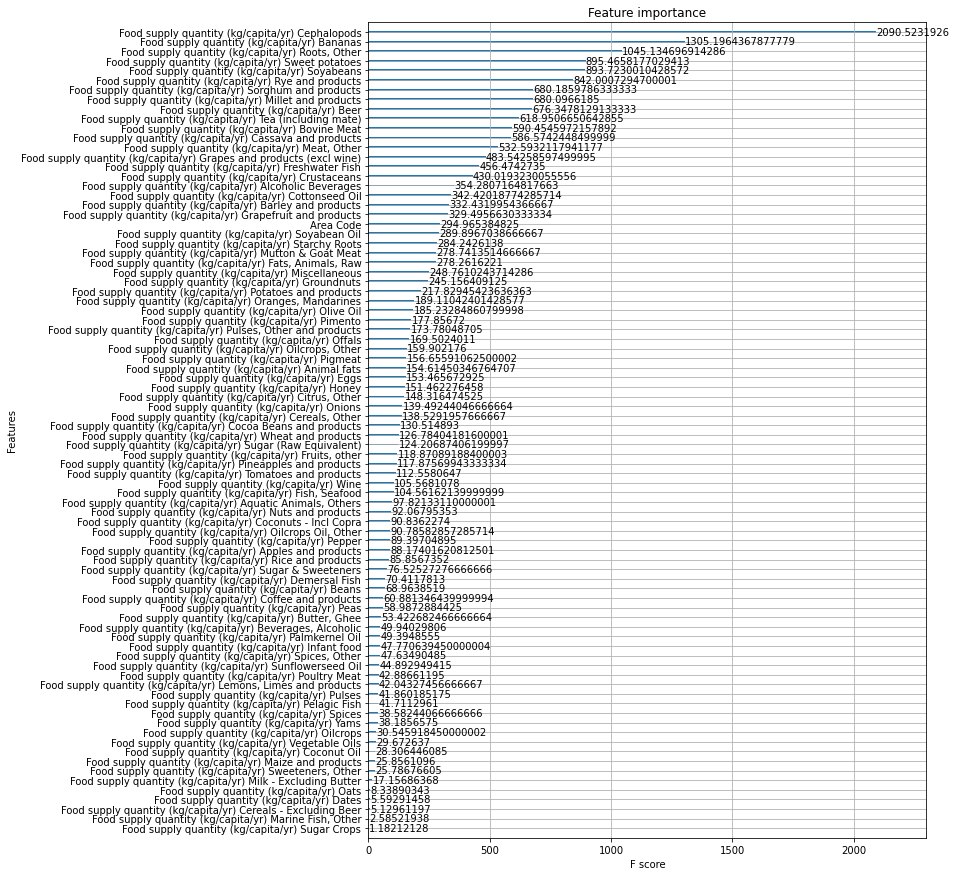

In [293]:
importance = model.get_booster().get_score(importance_type = "gain")
importance = {k: v for k, v in sorted(importance.items(), key = lambda item: item[1])}


fig, ax = plt.subplots(figsize = (10, 15))
plot_importance(model, importance_type = "gain", ax = ax);

In [294]:
df_impo = pd.DataFrame(importance.items(), columns=['Item', 'Importance']).reset_index()
df_impo.sort_values(by="Importance",  ascending=False).head(8)

,index,Item,Importance
83,83,Food supply quantity (kg/capita/yr) Cephalopods,2090.523193
82,82,Food supply quantity (kg/capita/yr) Bananas,1305.196437
81,81,"Food supply quantity (kg/capita/yr) Roots, Other",1045.134697
80,80,Food supply quantity (kg/capita/yr) Sweet potatoes,895.465818
79,79,Food supply quantity (kg/capita/yr) Soyabeans,893.723001
78,78,Food supply quantity (kg/capita/yr) Rye and products,842.000729
77,77,Food supply quantity (kg/capita/yr) Sorghum and products,680.185979
76,76,Food supply quantity (kg/capita/yr) Millet and products,680.096618


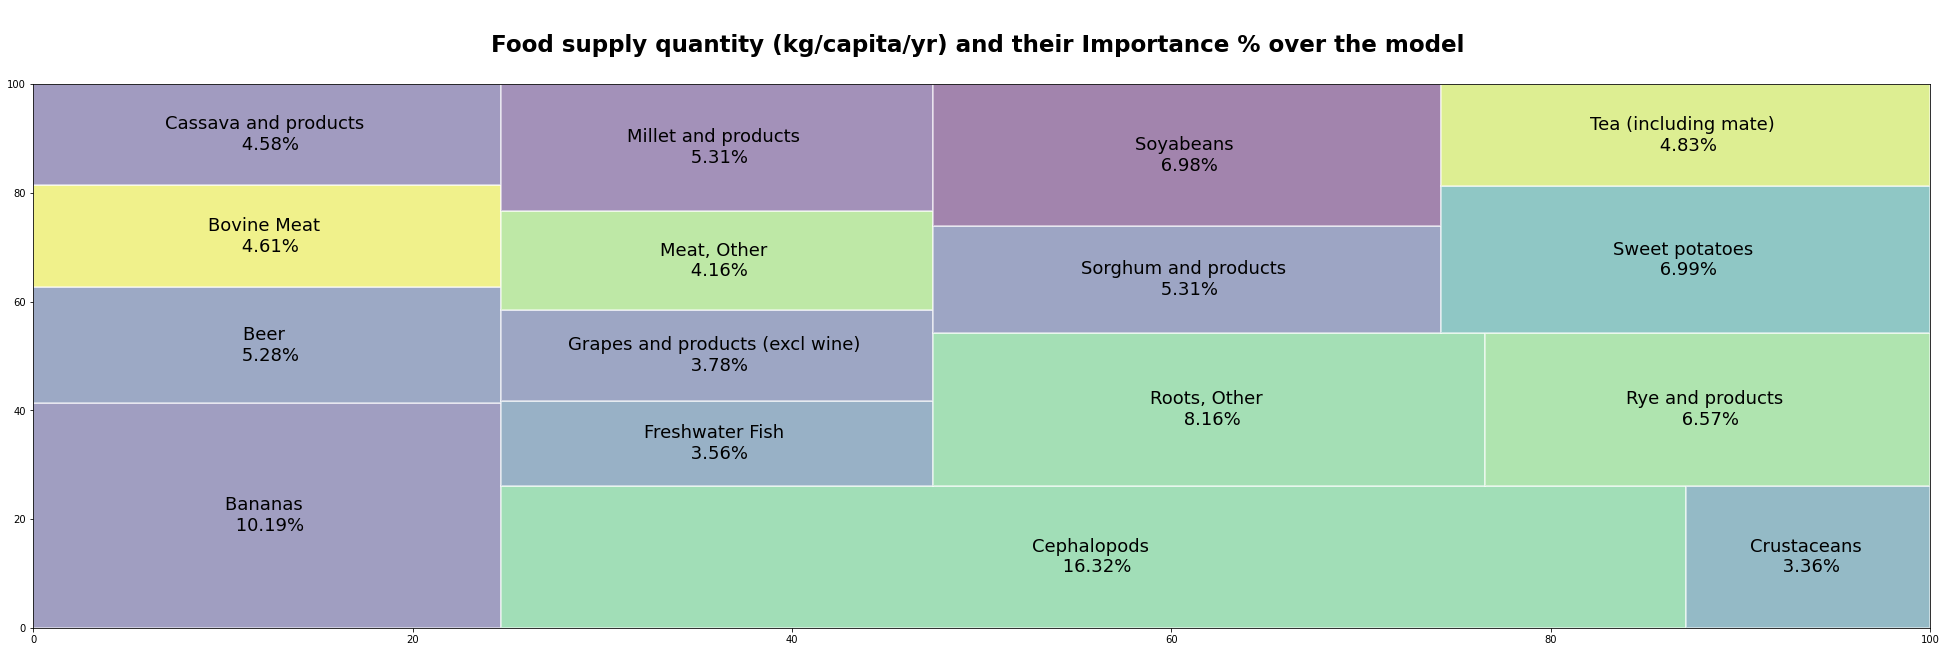

In [295]:


plot_tree_map(df_impo, "Item", "Importance","Food supply quantity (kg/capita/yr) and their Importance % over the model", "Food supply quantity (kg/capita/yr) ")



In [296]:
from sklearn import metrics
from math import sqrt
Y_valida_pred = model.predict(X_valida)

r2_valida = sqrt(metrics.r2_score(Y_valida, Y_valida_pred))
rmse_valida = sqrt(metrics.mean_squared_error(Y_valida, Y_valida_pred))
print("rmse",rmse_valida)
print("r2",r2_valida)

rmse 4.672724077831299
r2 0.5140925802227018


Accuracy: 34.63%


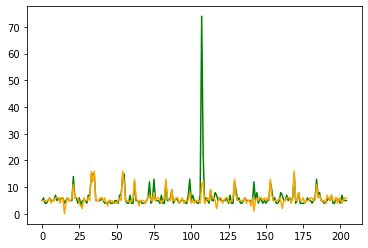

In [297]:
### to dos : quitar valores negativos_=?

### to dos : dividir emisiones per capita para dimensionarlos correctamente
index=0;
min_value = Y_valida_pred.min()
offset= 0-min_value

Y_valida_pred_off = Y_valida_pred+offset

min_value_valida = Y_valida.min()
offset_valida= 0-min_value_valida

Y_valida_off= Y_valida+offset



predictions = [round(value) for value in Y_valida_pred_off]
Y_valida_off = [round(value) for value in Y_valida_off]
# evaluate predictions
accuracy = metrics.accuracy_score(Y_valida_off, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

#plot each series
plt.plot(Y_valida_off, label='Real', color='green')
plt.plot(predictions, label='Prediction', color='orange')


#display plot
plt.show()

# Key differences between new and old Food Balance Sheet (FBS) methodology


---



The key difference between the new and old food balances (FBS) methodologies is **the absence of a balancer variable.**

 In the past, one of the components of the FBS (often stocks, industrial
utilization or feed) would take on **the outstanding unbalanced mounts thus inheriting all the statistical errors.**

With the new methodology, the imputations for the FBS components (the data
of which are often not provided by countries) are **generated by dedicated modules; and a
balancing mechanism** will then proportionally spread the imbalances out among all the
components.

The most important output of the FBS is the Dietary Energy Supply (DES) in kilocalories per
person per day in a given country. This DES is based on the imputations generated by the
dedicated new food module. 

This module, in year t, is heavily influenced by food in year t-1,
and considering that the other variables in the module are changes in real GDP, population, and
commodity demand elasticity – all of which do not usually exhibit large variations from one
year to another - **the food quantities can be assumed to be comparable between the two methodologies.** 

However, the FBS balancing mechanism, in allocating all available quantities
to the food component for ‘food only’ commodities (e.g. meat of cattle), may result in
discrepancies with the old time series. Further analysis of this still needs to be carried out. 
